In [6]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
from numba import jit
from rasterio.merge import merge
#from globalstack_functions import ih_flowdir, pq, sinkfill
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## This nb generates the grids used in QuickChi

### Download and unzip all GRID data from Hydrosheds Copy the cell below into the QGIS python console to load. Use qgis to merge the tiles into a 'dir.tif' grid with 16 bit int

In [10]:
#Qgis add all lyr

import os
dir1 = '/Users/gr_1/Documents/DEM_3s_GRID/as_dem_3s_zip_grid///'
n1=0
for nm in os.listdir(dir1): 
    if not('.' in nm):
        fs = os.listdir(dir1+nm)
        for f in fs:
            if not '.' in f:
                iface.addRasterLayer(dir1+'/'+nm+'/'+f)

NameError: name 'iface' is not defined

### Prepare the receiver grids - load in the direction grid

In [5]:
def zero_edges(y):
    y[:, 0] = 0
    y[0, :] = 0
    y[:, -1] = 0
    y[-1, :] = 0
    return y

### Now open the tif with the drainage directions 

In [11]:
f = rio.open('/Volumes/T7/dir.tif')
a_sub=f.read()
a_sub = np.uint16(a_sub.squeeze()) # Need to squeeze to remove extra dimension
a_sub = zero_edges(a_sub)

In [ ]:
lb = f.bounds.left
ub = f.bounds.top

In [7]:
## Now we convert hydrosheds drainage direction to x and y

In [ ]:
@jit()
def h_flowdir(d):
    #Translate flow dir from hydrosheds into flow dir from simplem format
    ny, nx = np.shape(d)
    sy = np.zeros(np.shape(d), dtype = np.int8) #slopes formatted correctly for simplem
    sx = np.zeros(np.shape(d), dtype = np.int8)
    for i in range(ny):
        for j in range(nx):
            d1 = d[i, j]
            if (d1 == 0) or (d1 == 255) or (d1 == 247): #0 is outlet to ocean, 255 is internally drained pour point
                sx[i, j] = 0
                sy[i, j] = 0
            elif d1 == 1:
                sx[i, j] = 1
                sy[i, j] = 0
            elif d1 == 2:
                sx[i, j] = 1
                sy[i, j] = 1
            elif d1 == 4:
                sx[i, j] = 0
                sy[i, j] = 1
            elif d1 == 8:
                sx[i, j] = -1
                sy[i, j] = 1
            elif d1 == 16:
                sx[i, j] = -1
                sy[i, j] = 0
            elif d1 == 32:
                sx[i, j] = -1
                sy[i, j] = -1
            elif d1 == 64:
                sx[i, j] = 0
                sy[i, j] = -1
            elif d1 == 128:
                sx[i, j] = 1
                sy[i, j] = -1
            
    return sx, sy

In [13]:
sx, sy = h_flowdir(a_sub);

In [ ]:
np.save('/Volumes/T7/stack_rx2.npy',sx)
np.save('/Volumes/T7/stack_ry2.npy',sy)

In [ ]:
del(sy)## Considerable memory allocation may require deletion, then we reload as memory mapped grids
del(sx)
del(a_sub)

## reload as memory mapped grids

In [7]:
sx = np.load('/Volumes/Samsung_T5/stack_rx.npy',mmap_mode='r')
sy = np.load('/Volumes/Samsung_T5/stack_ry.npy',mmap_mode='r')

#Ix = np.load('/Volumes/T7/sa_IX.npy',mmap_mode='r')
#Iy = np.load('/Volumes/T7/sa_Iy.npy',mmap_mode='r')
#I = np.load('/Volumes/Samsung_T5/stack_I.npy',mmap_mode='r')

In [5]:
#np.load('/Volumes/Samsung_T5/Af_ac.tif.npy', mmap_mode='r')

## Now we caluclate the stack - there are 3 sets of functions.  The first cell calculates both x and y stack at the same time.  If we run out of memory, however, we only want to calculate one at a time.  This is what the next 2 cells are for.  For me, this was only an issue for Africa and Eurasia

In [8]:
import math
@jit(nopython=True)
def lind(xy,n):
    #Compute linear index from 2 points
    x=math.floor(xy/n)
    y=xy%n
    return int(y),int(x)

@jit(nopython=True)
def stack(sx, sy):
    #This takes the input s and makes the topologic stack of the stream network in O(n) time
    c=0
    k=0
    ny, nx = np.shape(sx)
    Ix = np.zeros(ny*nx, dtype= np.uint32)
    Iy = np.zeros(ny*nx, dtype= np.uint32)
    for i in range(ny):
        for j in range(nx):

            ij = j * ny + i
            i2 = i
            j2 = j
            if sx[i, j] == 0 and sy[i,j] == 0:

                Ix[c]=int(ij / ny)
                Iy[c]=int(ij % ny)
                c+=1

                while c>k and c < ny * nx - 1 :
                    for i1 in range(-1, 2):
                        for j1 in range(-1, 2):
                                if j2 + j1 > 0 and i2 + i1 > 0 and j2 + j1 < nx - 1 and i2 + i1 < ny - 1:
                                    ij2 = (j2 + j1) * ny + i2 + i1
                                    #print(s[i2 + i1, j2 + j1])

                                    if (i1 != 0 or j1 != 0) and sy[int(i2 + i1), 
                                                                  int(j2 + j1)] + i1 == 0 and sx[int(i2 + i1), 
                                                                  int(j2 + j1)] + j1 == 0:
                                        #I[c] = ij2
                                        Ix[c] = int(ij2 / ny)
                                        Iy[c] = int(ij2 % ny)
                                        c+=1

                    k = k+1
                    ij = Ix[k] * ny + Iy[k]
                    i2,j2=lind(ij,ny)
        if np.mod(i,1000) == 0:
            print('##')
            print(c)
            print(i/ny)
    return Ix, Iy


In [9]:
### Only Ix

import math
@jit(nopython=True)
def lind(xy,n):
    #Compute linear index from 2 points
    x=math.floor(xy/n)
    y=xy%n
    return int(y),int(x)

@jit(nopython=True)
def stack(sx, sy):
    #This takes the input s and makes the topologic stack of the stream network in O(n) time
    c=0
    k=0
    c2=0
    k2=0
    ny, nx = np.shape(sx)
    Ix = np.zeros(ny*nx, dtype= np.uint32)
    Iy = np.zeros(int(ny*nx/3), dtype= np.uint32)
    for i in range(1,ny-1):
        for j in range(1,nx-1):

            ij = j * ny + i
            i2 = i
            j2 = j
            if sx[i, j] == 0 and sy[i,j] == 0:
                c2=0
                k2=0
                Ix[c]=int(ij / ny)
                Iy[c2]=int(ij % ny)
                c+=1
                c2+=1
                while c>k and c < ny * nx - 1 :

                    for i1 in range(-1, 2):
                        for j1 in range(-1, 2):
                                if j2 + j1 > 0 and i2 + i1 > 0 and j2 + j1 < nx - 1 and i2 + i1 < ny - 1:
                                    ij2 = (j2 + j1) * ny + i2 + i1
                                    #print(s[i2 + i1, j2 + j1])

                                    if (i1 != 0 or j1 != 0) and sy[int(i2 + i1), 
                                                                  int(j2 + j1)] + i1 == 0 and sx[int(i2 + i1), 
                                                                  int(j2 + j1)] + j1 == 0:
                                        #I[c] = ij2
                                        Ix[c] = int(ij2 / ny)
                                        Iy[c2] = int(ij2 % ny)
                                        
                                        c+=1
                                        c2+=1
                                        

                    k = k+1
                    k2+=1
                    ij = Ix[k] * ny + Iy[k2]
                    i2,j2=lind(ij,ny)
                    if c2%10000000 ==0:
                        print(c2)
                        print((i2,j2))
                    
        if np.mod(i,1000) == 0:
            print('##')
            print(c)
            print(i/ny)
    return Ix#, Iy


In [11]:
### Only Iy

import math
@jit(nopython=True)
def lind(xy,n):
    #Compute linear index from 2 points
    x=math.floor(xy/n)
    y=xy%n
    return int(y),int(x)

@jit(nopython=True)
def stack(sx, sy):
    #This takes the input s and makes the topologic stack of the stream network in O(n) time
    c=0
    k=0
    c2=0
    k2=0
    ny, nx = np.shape(sx)
    Iy = np.zeros(ny*nx, dtype= np.uint32)
    Ix = np.zeros(int(ny*nx/3), dtype= np.uint32)
    for i in range(1,ny-1):
        for j in range(1,nx-1):

            ij = j * ny + i
            i2 = i
            j2 = j
            if sx[i, j] == 0 and sy[i,j] == 0:
                c2=0
                k2=0
                Ix[c2]=int(ij / ny)
                Iy[c]=int(ij % ny)
                c+=1
                c2+=1
                while c>k and c < ny * nx - 1 :

                    for i1 in range(-1, 2):
                        for j1 in range(-1, 2):
                                if j2 + j1 > 0 and i2 + i1 > 0 and j2 + j1 < nx - 1 and i2 + i1 < ny - 1:
                                    ij2 = (j2 + j1) * ny + i2 + i1
                                    #print(s[i2 + i1, j2 + j1])

                                    if (i1 != 0 or j1 != 0) and sy[int(i2 + i1), 
                                                                  int(j2 + j1)] + i1 == 0 and sx[int(i2 + i1), 
                                                                  int(j2 + j1)] + j1 == 0:
                                        #I[c] = ij2
                                        Ix[c2] = int(ij2 / ny)
                                        Iy[c] = int(ij2 % ny)
                                        
                                        c+=1
                                        c2+=1
                                        

                    k = k+1
                    k2+=1
                    ij = Ix[k2] * ny + Iy[k]
                    i2,j2=lind(ij,ny)
                    if c2%10000000 ==0:
                        print(c2)
                        print((i2,j2))
                    
        if np.mod(i,1000) == 0:
            print('##')
            print(c)
            print(i/ny)
    return Iy

In [7]:
Iy = stac/Volumes/Macintosh HD/

10000000
(3189, 54025)
10000000
(4027, 50634)
##
126524829
0.011904761904761904
##
223976750
0.023809523809523808
##
326170474
0.03571428571428571
##
440761842
0.047619047619047616
##
547490499
0.05952380952380952
##
642795107
0.07142857142857142
10000000
(5684, 175179)
##
767822654
0.08333333333333333
20000000
(4498, 73369)
30000000
(3126, 77127)
40000000
(5231, 72063)
70000000
(6199, 82020)
70000000
(6203, 82018)
80000000
(7270, 72990)
80000000
(7270, 72991)
100000000
(5321, 69015)
110000000
(1974, 78967)
130000000
(2154, 82618)
150000000
(7639, 67193)
170000000
(7277, 64478)
170000000
(7278, 64478)
180000000
(4767, 61931)
180000000
(4769, 61933)
180000000
(4769, 61934)
190000000
(4193, 89051)
200000000
(952, 59980)
210000000
(4925, 60931)
230000000
(8487, 61523)
##
1094307835
0.09523809523809523
10000000
(7958, 42481)
20000000
(8069, 45171)
20000000
(8070, 45169)
10000000
(10441, 33406)
20000000
(13412, 34329)
##
1258208255
0.10714285714285714
10000000
(12522, 38383)
##
1365973236
0

IOStream.flush timed out



1454131399
0.13095238095238096
10000000
(13209, 28035)
30000000
(8510, 56488)
30000000
(8511, 56488)
50000000
(6348, 55645)
30000000
(8739, 88019)
30000000
(12750, 175385)
30000000
(12751, 175385)
30000000
(12751, 175386)
30000000
(12744, 175452)
30000000
(12744, 175453)
30000000
(12747, 175454)
70000000

IOStream.flush timed out
IOStream.flush timed out



(17886, 172556)
70000000
(17887, 172559)
80000000
(11479, 174516)
90000000
(11812, 175482)
90000000
(11812, 175483)
100000000
(16324, 168088)
100000000
(16325, 168086)
100000000
(16325, 168088)
100000000
(16326, 168088)
100000000
(16333, 168093)
110000000
(9597, 169125)
120000000
(9114, 171949)
130000000
(10049, 173550)
160000000

IOStream.flush timed out



(6884, 170604)
160000000
(6885, 170604)
170000000
(14826, 163537)
170000000
(14827, 163537)
190000000
(7954, 162999)
200000000
(6422, 164608)
210000000
(8556, 164066)
210000000
(8557, 164066)
210000000
(8558, 164065)
220000000
(12456, 165008)
230000000
(12041, 164464)
250000000
(7482, 158443)
260000000
(11061, 159343)
270000000
(11013, 155163)
310000000
(12514, 150020)
390000000
(18795, 147329)
400000000
(16238, 146303)
400000000
(16239, 146303)
410000000
(16364, 145637)
410000000
(16364, 145638)
410000000
(16364, 145639)
410000000
(16364, 145640)
410000000
(16365, 145637)
420000000
(21731, 144636)
420000000
(21727, 144641)
420000000
(21727, 144642)
450000000
(23410, 143360)
450000000
(23406, 143361)
450000000
(23406, 143362)
450000000
(23407, 143362)
450000000
(23408, 143362)
460000000
(20234, 155198)
470000000
(21128, 155411)
470000000
(21128, 155412)
470000000
(21129, 155412)
470000000
(21103, 155422)
470000000
(21104, 155419)
470000000
(21105, 155419)
470000000
(21106, 155420)
490

IOStream.flush timed out



510000000
(21090, 134066)


IOStream.flush timed out
IOStream.flush timed out


##
2184531386
0.14285714285714285
##
2280374779
0.15476190476190477
##

IOStream.flush timed out



2382644043
0.16666666666666666
10000000
(11181, 62149)
10000000
(11182, 62149)
10000000
(11183, 62148)
10000000
(11184, 62145)
10000000
(12927, 56121)
10000000
(11954, 69034)
10000000
(11954, 69035)
10000000
(11954, 69036)
20000000
(11420, 63975)
40000000
(9045, 69785)
##
2574796522
0.17857142857142858
10000000
(16662, 20449)
10000000
(16667, 20442)
##
2697841172
0.19047619047619047
20000000
(14028, 89837)
20000000
(14028, 89838)
20000000
(14015, 89843)
30000000
(12536, 93538)
30000000
(12536, 93539)
40000000
(12826, 88648)
50000000
(11444, 89028)


IOStream.flush timed out


##
2876976555
0.20238095238095238
10000000
(15348, 40379)
10000000
(15350, 40380)
20000000
(19747, 87257)
30000000
(20708, 95728)
100000000
(18383, 104205)
100000000
(18384, 104204)
110000000
(23732, 98605)
130000000
(13909, 104972)
140000000
(25684, 95778)
140000000
(25684, 95779)
160000000

IOStream.flush timed out
IOStream.flush timed out



(26184, 97295)
160000000
(26187, 97297)
160000000
(26187, 97298)
180000000
(25795, 96737)
200000000
(28250, 100613)
210000000
(18615, 106081)
220000000
(19301, 107965)
230000000
(15957, 112415)
250000000
(24438, 104621)
250000000
(24437, 104615)
250000000
(24437, 104616)
250000000
(24438, 104616)
250000000
(24439, 104616)
260000000
(17782, 113299)
270000000
(19885, 110371)
280000000
(18690, 115980)
290000000
(18882, 114948)
300000000
(20327, 114436)
320000000
(18979, 121354)
330000000
(18294, 128812)
340000000
(18869, 132654)
350000000
(18375, 135166)
350000000
(18375, 135167)
350000000
(18378, 135162)
360000000
(17150, 131672)
360000000
(17150, 131673)
##
3399821544
0.21428571428571427
20000000
(20481, 40245)
30000000
(15052, 34969)
40000000
(15455, 36270)
40000000
(15457, 36268)
50000000
(13850, 33129)
##
3615223290
0.2261904761904762
##
3768891737
0.23809523809523808
10000000
(20519, 129931)
20000000
(24086, 126755)
20000000
(24087, 126755)
20000000
(24086, 126759)
40000000
(23149,

In [10]:
Ix = stack(sx, sy)

10000000
(3189, 54025)
10000000
(4027, 50634)
##
126524829
0.011904761904761904
##
223976750
0.023809523809523808
##
326170474
0.03571428571428571
##
440761842
0.047619047619047616
##
547490499
0.05952380952380952
##
642795107
0.07142857142857142
10000000
(5684, 175179)
##
767822654
0.08333333333333333
20000000
(4498, 73369)
30000000
(3126, 77127)
40000000
(5231, 72063)
70000000
(6199, 82020)
70000000
(6203, 82018)
80000000
(7270, 72990)
80000000
(7270, 72991)
100000000
(5321, 69015)
110000000
(1974, 78967)
130000000
(2154, 82618)
150000000
(7639, 67193)
170000000
(7277, 64478)
170000000
(7278, 64478)
180000000
(4767, 61931)
180000000
(4769, 61933)
180000000
(4769, 61934)
190000000
(4193, 89051)
200000000
(952, 59980)
210000000
(4925, 60931)
230000000
(8487, 61523)
##
1094307835
0.09523809523809523
10000000
(7958, 42481)
20000000
(8069, 45171)
20000000
(8070, 45169)
10000000
(10441, 33406)
20000000
(13412, 34329)
##
1258208255
0.10714285714285714
10000000
(12522, 38383)
##
1365973236
0

In [10]:
np.save('/Volumes/T7/sa_Iy', Iy)

In [11]:
np.save('/Volumes/T7/sa_Ix', Ix)

In [12]:
del(Ix)

In [ ]:
del(Iy)

## The beginning of acc caluclation

In [13]:
import numpy as np
from numba import jit

In [14]:
size = (96000, 94800) # Africa
size = (84000, 232800) # Asia
size = np.shape(sx)

In [15]:
Ix = np.load('/Volumes/T7/sa_Ix.npy', mmap_mode='r')
Iy = np.load('/Volumes/T7/sa_Iy.npy', mmap_mode='r')
#sx = np.load('/Volumes/T7/stack_rx.npy', mmap_mode='r')
#sy = np.load('/Volumes/T7/stack_ry.npy', mmap_mode='r')

In [16]:
@jit(nopython=True)
def acc(sx, sy, Ix, Iy, size):#Calculate drainage area
    A = np.ones(size, dtype=np.uint32)
    ny, nx = size
    c=0
    for ij in range(len(Ix)-1,-1,-1):
        j = Ix[ij]
        i = Iy[ij]
        ij1 = i + j * ny
        j2 = int(sx[ij])+j
        i2 = int(sy[ij])+i

        if sy[ij] != 0 or sx[ij]!=0:
            A[i2, j2] += A[i, j]

        if ij1 % 1000000 == 0:
            print(ij/len(Ix) )
            c+=1                    #
    return A

In [17]:
## normal
@jit(nopython=True)
def acc(sx, sy, Ix, Iy, size):#Calculate drainage area
    A = np.ones(size, dtype=np.uint32)
    ny, nx = size
    c=0
    for ij in range(len(Ix)-1,-1,-1):
        j = Ix[ij]
        i = Iy[ij]
        ij1 = i + j * ny


        j2 = int(sx[i,j])+j 
        i2 = int(sy[i,j])+i

        if sy[i,j] != 0 or sx[i,j]!=0:
            A[i2, j2] += A[i, j]

        if ij % 1000000 == 0:
            print(ij/len(Ix) )
            c+=1

                        #
    return A

In [18]:
#size = (96000, 94800)
A = acc(sx, sy, Ix, Iy, size)

0.9999897725413189
0.9999386352479136
0.9998874979545083
0.9998363606611029
0.9997852233676976
0.9997340860742923
0.9996829487808869
0.9996318114874816
0.9995806741940763
0.9995295369006709
0.9994783996072656
0.9994272623138603
0.9993761250204549
0.9993249877270496
0.9992738504336443
0.9992227131402389
0.9991715758468336
0.9991204385534282
0.9990693012600229
0.9990181639666176
0.9989670266732122
0.9989158893798069
0.9988647520864016
0.9988136147929962
0.9987624774995909
0.9987113402061856
0.9986602029127802
0.9986090656193749
0.9985579283259696
0.9985067910325642
0.9984556537391589
0.9984045164457536
0.9983533791523482
0.9983022418589429
0.9982511045655376
0.9981999672721322
0.9981488299787269
0.9980976926853216
0.9980465553919162
0.9979954180985109
0.9979442808051056
0.9978931435117002
0.9978420062182949
0.9977908689248896
0.9977397316314842
0.9976885943380789
0.9976374570446735
0.9975863197512682
0.9975351824578629
0.9974840451644575
0.9974329078710522
0.9973817705776469
0.9973306332

In [19]:
np.save('/Volumes/T7/sa_acc', A)

In [20]:
del(A)

In [22]:
import geopandas as gpd

In [25]:
a = gpd.read_file('/Users/gr_1/Documents/streamprofiler/af_bound')

In [32]:
a.to_file('/Users/gr_1/Documents/af',driver='GeoJSON')

In [ ]:
str(a.to_json())

## Brief Test

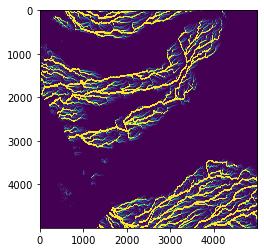

In [109]:
plt.imshow(A[15000:20000,15000:20000],vmax=1000,vmin=0)

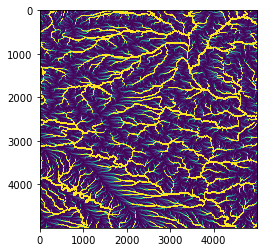

In [9]:
plt.imshow(A[10000:15000,50000:55000],vmin = 0,vmax = 1000)

## For custom flow routing.  This section prepares the grids for what I called the 'd8' flow routing method based on pit-filled grids created using the create_pit_filled.py scipt.  It should actually be run first, so perhaps this is poorly organized in that sense, but I did not think that many people would be using it so...

In [28]:
Z = np.load('/Volumes/Samsung_T5/eu/others/dem.npy',mmap_mode='r')#[20000:25000,20000:25000]

In [76]:
Z = np.load('/Volumes/T7/mars/others/acc.npy',mmap_mode='r')#[20000:25000,20000:25000]

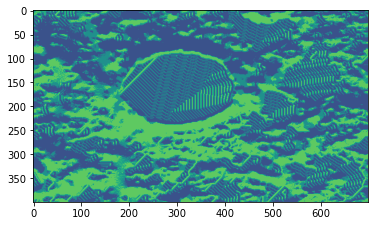

In [87]:
plt.imshow(sx[11400:11800,11800:12500],vmin=-2,vmax=2)

In [29]:
@jit(nopython=True)
def slp(Z):#Calculate slope and steepest descent
    ij=0  
    c=0
    sx = np.zeros(np.shape(Z),dtype = np.int8)
    sy = np.zeros(np.shape(Z),dtype = np.int8)
    ny, nx = np.shape(Z)
    for i in range(0,ny):
        for j in range(0,nx):
            ij=j*ny+i
            mxi=0
            sx[i,j]=0
            sy[i,j]=0
            if (i>0 and i< ny and j>0 and j< nx-1 and i< ny-1):
                for i1 in range(-1,2):
                    for j1 in range(-1,2):
                        if (Z[i,j]-Z[i+i1,j+j1])/np.sqrt((float(i1)**2)+float(j1)**2+1e-10)>mxi:
                            ij2=(j+j1)*ny+i1+i
                            mxi=(Z[i,j]-Z[i+i1,j+j1])/np.sqrt((float(i1)**2)+float(j1)**2)
                            sx[i,j]=j1
                            sy[i,j]=i1
                if mxi == 0:
                    c += 1
                    #fnd[i,j] = 1
        if np.mod(i,1000) == 0:
            print(i/ny)
    print(c)
    return sx, sy

In [ ]:
#dem =  n/Volumes/Samsung_T5/umes/T7/arr_0.npy',mmap_mode='r')
sx, sy = slp(Z)
#np.save('/Volumes/T7/eu2/rs/stack_rx.npy',sx)

In [32]:
np.save('/Volumes/Samsung_T5/stack_rx',sx)

In [34]:
np.save('/Volumes/Samsung_T5//stack_ry',sy)

In [ ]:
del(sx)
del(sy)

In [56]:
np.where(sx[:,0]<0)

(array([], dtype=int64),)